In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from seaborn import heatmap
from pickle import dump, load
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import LocallyLinearEmbedding, TSNE
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [2]:
# read in datasets
Train_in,Train_out = pd.read_csv("train_in.csv", header=None), pd.read_csv("train_out.csv",header=None)
Test_in, Test_out  = pd.read_csv("test_in.csv", header=None), pd.read_csv("test_out.csv", header=None)

# Data Visualization

## Principal Component Analysis (PCA)

Starting from the third, every additional component only contributes insignificantly to explaining the variance in training data; in other words, 2D visualization should suffice to reveal the important information. Only digit $0$ and $1$ manage to have a local area occupied by the point representations of most their images. Other clusters are completely mixed up with each other.

In [3]:
# how important are the first 5 components
p = PCA(n_components=5)
X = p.fit_transform(Train_in)
p.explained_variance_ratio_

array([0.19313806, 0.0922871 , 0.06794816, 0.05172565, 0.04849809])

In [4]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Train_in)

In [35]:
random.seed(149)
CLR = [tuple(np.random.uniform(size=3)) for digit in np.unique(Train_out.loc[:,0])] # 10 colors

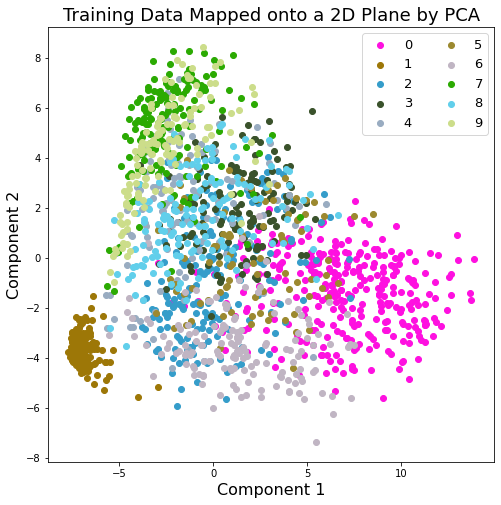

In [36]:
# Visualize results

def dataviz(X, y, CLR, approach, XL="Dimension 1", YL="Dimension 2"):
    plt.figure(figsize=(8,8))
    for digit,c in zip(np.unique(Train_out.loc[:,0]),CLR):
        coords = X[[i for i,val in enumerate(y) if val==digit],:]
        plt.scatter(coords[:,0], coords[:,1], color=c, label=digit)
    plt.title("Training Data Mapped onto a 2D Plane by "+approach, fontsize=18)
    plt.xlabel(XL, fontsize=16)
    plt.ylabel(YL, fontsize=16)
    plt.legend(loc="upper right", fontsize=13, ncol=2)
    plt.savefig(approach+".png")
    plt.show()

dataviz(X_pca, Train_out.loc[:,0], CLR, approach="PCA", XL="Component 1", YL="Component 2")

## Locally Linear Embeddings (LLE)

Suppose data points are roughly located on a manifold in high-dimensional space and unfold it by approximating local neighborhood with a plane. Only the unfolded cluster of digit $1$ appears to be notably separable from the others, although distance is not preserved during the unfolding so we do not know how large the proportions of images of digit $0$ and $7$ are in the small areas they seem to dominate respectively.

In [8]:
# LLE
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=15)
X_lle = lle.fit_transform(Train_in)

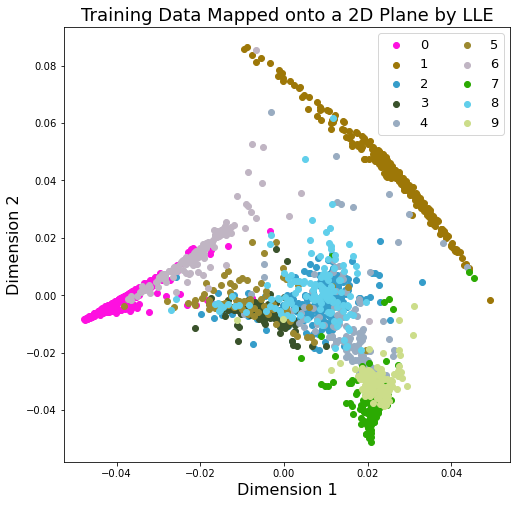

In [37]:
# Visualize results
dataviz(X_lle, Train_out.loc[:,0], CLR, approach="LLE")

## t-distributed Stochastic Neighbor Embedding (t-SNE)

Despite the instrinsic endeavor to preserve with probability the proximity of data points in the mapping, the cluster of digit $3$ is almost entirely imbedded in that of digit $8$, and $7$ in $9$. The cluster of digit $4$ does not have a clear boundary with that of $7$; neither does $5$ with $3$. In fact, the cluster of $5$ itself looks not quite definite, presumably due to **(i)** notably fewer instances and **(ii)** the wild variations of how people write $5$ by hand. One cannot expect a distance-based algorithm to divide these clusters very accurately, but the clusters of digit $0$, $1$, $2$, and $6$ are well isolated.

In [10]:
# t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(Train_in)

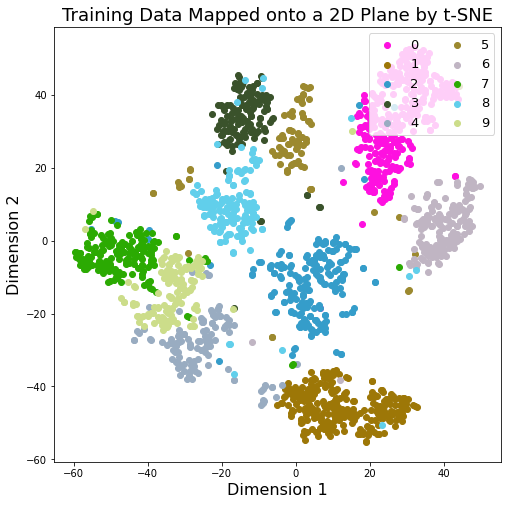

In [38]:
# Visualize results
dataviz(X_tsne, Train_out.loc[:,0], CLR, approach="t-SNE")

# Distance-based Classification

## Naive Classifier

Define the center of a digit cluster by the the average coordinates of the point representations in the $256$-dimensional space of all images of that digit in the training set. Intuitively speaking, the closer the centers of two clusters, the more difficult to separate the clusters. Therefore, if an image is classified by the nearest cluster center, then $7$ and $9$ are expected to be the least indistinguishable, and missclassification is reasonably probable between $4$ and $9$, and $3$ and $5$. In addition, the cluster center of digit $0$ and that of digit $1$ are relatively far away from other cluster centers, suggesting that the hand-writing of these two digits is more recognizable. 

In [12]:
# Naive Classifier
class CLF_naive:
    Centers = dict()
    Distance_Matrix = 0
    
    def fit(self, DF_input, output):
        for digit in np.unique(output):
            row_IDs = [row for row in range(len(output)) if output[row]==digit]
            self.Centers[digit] = DF_input.loc[row_IDs,:].mean(axis=0).to_numpy()
        m = len(np.unique(output))
        D = np.zeros([m,m])
        for i in range(m):
            for j in range(m):
                D[i,j] = np.sqrt(np.sum((self.Centers[i]-self.Centers[j])**2))
        self.Distance_Matrix = pd.DataFrame(D, index=[i for i in range(m)], columns=[j for j in range(m)])
        
    def predict(self, DF_input):
        pred = list()
        for row in range(DF_input.shape[0]):
            coords = DF_input.loc[row,:]
            lst = [(np.sum((coords - self.Centers[digit])**2), digit) for digit in self.Centers.keys()]
            lst.sort()
            pred.append(lst[0][1])
        return pred

In [13]:
# distance matrix
naive = CLF_naive()
naive.fit(Train_in, Train_out.loc[:,0])
naive.Distance_Matrix

,0,1,2,3,4,5,6,7,8,9
0,0.000000,14.449608,9.334556,9.143734,10.769844,7.519296,8.154443,11.864555,9.907902,11.488875
1,14.449608,0.000000,10.125323,11.733233,10.173786,11.118800,10.614700,10.743154,10.086777,9.932094
2,9.334556,10.125323,0.000000,8.178285,7.932541,7.906796,7.331808,8.872531,7.077516,8.887748
3,9.143734,11.733233,8.178285,0.000000,9.087608,6.118750,9.302065,8.922401,7.020425,8.354350
4,10.769844,10.173786,7.932541,9.087608,0.000000,8.001517,8.782233,7.583012,7.380909,6.010408
5,7.519296,11.118800,7.906796,6.118750,8.001517,0.000000,6.698692,9.211954,6.967386,8.258538
6,8.154443,10.614700,7.331808,9.302065,8.782233,6.698692,0.000000,10.888237,8.587222,10.440004
7,11.864555,10.743154,8.872531,8.922401,7.583012,9.211954,10.888237,0.000000,8.467785,5.426474
8,9.907902,10.086777,7.077516,7.020425,7.380909,6.967386,8.587222,8.467785,0.000000,6.401166
9,11.488875,9.932094,8.887748,8.354350,6.010408,8.258538,10.440004,5.426474,6.401166,0.000000


In [14]:
naive.Distance_Matrix.to_latex(float_format="%.2f")

'\\begin{tabular}{lrrrrrrrrrr}\n\\toprule\n{} &     0 &     1 &     2 &     3 &     4 &     5 &     6 &     7 &     8 &     9 \\\\\n\\midrule\n0 &  0.00 & 14.45 &  9.33 &  9.14 & 10.77 &  7.52 &  8.15 & 11.86 &  9.91 & 11.49 \\\\\n1 & 14.45 &  0.00 & 10.13 & 11.73 & 10.17 & 11.12 & 10.61 & 10.74 & 10.09 &  9.93 \\\\\n2 &  9.33 & 10.13 &  0.00 &  8.18 &  7.93 &  7.91 &  7.33 &  8.87 &  7.08 &  8.89 \\\\\n3 &  9.14 & 11.73 &  8.18 &  0.00 &  9.09 &  6.12 &  9.30 &  8.92 &  7.02 &  8.35 \\\\\n4 & 10.77 & 10.17 &  7.93 &  9.09 &  0.00 &  8.00 &  8.78 &  7.58 &  7.38 &  6.01 \\\\\n5 &  7.52 & 11.12 &  7.91 &  6.12 &  8.00 &  0.00 &  6.70 &  9.21 &  6.97 &  8.26 \\\\\n6 &  8.15 & 10.61 &  7.33 &  9.30 &  8.78 &  6.70 &  0.00 & 10.89 &  8.59 & 10.44 \\\\\n7 & 11.86 & 10.74 &  8.87 &  8.92 &  7.58 &  9.21 & 10.89 &  0.00 &  8.47 &  5.43 \\\\\n8 &  9.91 & 10.09 &  7.08 &  7.02 &  7.38 &  6.97 &  8.59 &  8.47 &  0.00 &  6.40 \\\\\n9 & 11.49 &  9.93 &  8.89 &  8.35 &  6.01 &  8.26 & 10.44 &  5.43

In [15]:
# classify training images
pred_naive_train = naive.predict(Train_in)
CM_naive_train = confusion_matrix(Train_out.loc[:,0], pred_naive_train, normalize='true')

# classify test images
pred_naive_test = naive.predict(Test_in)
CM_naive_test = confusion_matrix(Test_out.loc[:,0], pred_naive_test, normalize='true')

# save results
CM_naive = {"Train":pd.DataFrame(CM_naive_train, index=[d for d in range(1+9)], columns=[d for d in range(1+9)]),
            "Test":pd.DataFrame(CM_naive_test, index=[d for d in range(1+9)], columns=[d for d in range(1+9)])}
dump(CM_naive, open("Confusion_Matrix_naive.p","wb"))

In [16]:
# performance
def evaluate(truth, predicted):
    P = precision_score(truth, predicted, average="macro")
    R = recall_score(truth, predicted, average="macro")
    F = f1_score(truth, predicted, average="macro")
    return [P, R, F]

Performance = dict()
Performance["Naive"] = evaluate(Test_out.loc[:,0], pred_naive_test)

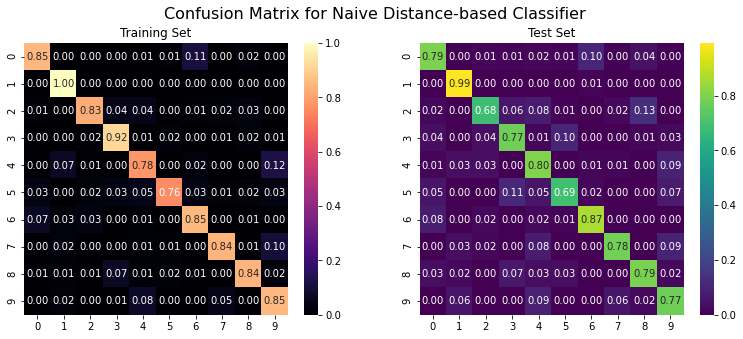

In [17]:
# visualize confusion matrix
def CM_viz(CM_dict, CBAR, title, name):
    fig, axs = plt.subplots(1,2, figsize=(13,5))
    fig.suptitle("Confusion Matrix for "+title, fontsize=16)
    heatmap(CM_dict["Train"], cmap=CBAR[0], annot=True, fmt=".2f", cbar=True, ax=axs[0])
    axs[0].set_title("Training Set")
    heatmap(CM_dict["Test"], cmap=CBAR[1], annot=True, fmt=".2f", cbar=True, ax=axs[1])
    axs[1].set_title("Test Set")
    plt.savefig("Confusion_Matrix_"+name+".png")
    plt.show()

CM_viz(CM_naive, ['magma','viridis'], "Naive Distance-based Classifier", 'naive')

It is true that $4$ and $7$ are frequently mislablled as $9$, **both for the training set and the test set**, while it happens less often the other way around. Also, $1$ is almost always classified correctly as we expected. To our surprise, it seems difficult to distinguish between $0$ and $6$, which is only anticipated in the visualization with LLE. 

Another surprise is that the missclassification between $3$ and $5$ only signifies in the test set, even though the two cluster centers are relatively close, and their 2D representations of training data mix up with each other in all visualizations. Moreover, $2$ is remarkably likely to be mislablled as $8$ **for the test set**, a phenomenon unseen for the training set.

## K-Nearest-Neighbor (KNN) Classifier

Assigning a data point the most common label in its neighborhood works very well for the training set in general. As for the test set, $5$ is frequently missclassified as $0$ and $3$.

In [18]:
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(Train_in, Train_out.loc[:,0])

KNeighborsClassifier(n_neighbors=6)

In [19]:
# classify training images
pred_knn_train = knn.predict(Train_in)
CM_knn_train = confusion_matrix(Train_out.loc[:,0], pred_knn_train, normalize='true')

# classify test images
pred_knn_test = knn.predict(Test_in)
CM_knn_test = confusion_matrix(Test_out.loc[:,0], pred_knn_test, normalize='true')

# save results
CM_knn = {"Train":pd.DataFrame(CM_knn_train, index=[d for d in range(1+9)], columns=[d for d in range(1+9)]),
          "Test":pd.DataFrame(CM_knn_test, index=[d for d in range(1+9)], columns=[d for d in range(1+9)])}
dump(CM_knn, open("Confusion_Matrix_knn.p","wb"))

In [20]:
# performance
Performance["KNN (K=6)"] = evaluate(Test_out.loc[:,0], pred_knn_test)

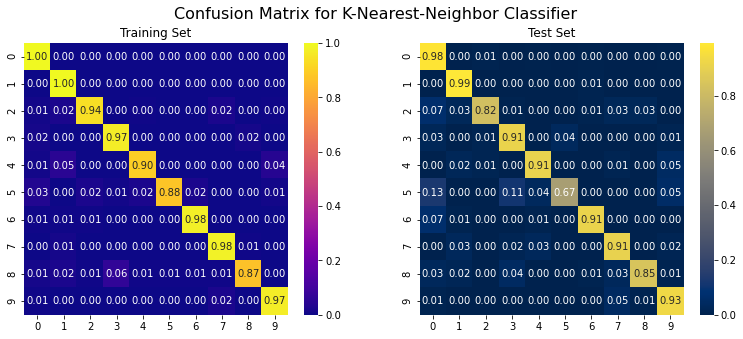

In [21]:
# visualize confusion matrix

CM_viz(CM_knn, ['plasma','cividis'], "K-Nearest-Neighbor Classifier", 'knn')

# Multi-class Perceptron Classifier

Set $10$ nodes to represent $10$ digits respectively, and label an input with the node that output the largest value. The $j^{th}$ column of the weight matrix $\mathbf{W}_{257 \times 10} = [\vec{w_1}, ..., \vec{w_{10}}]$ specifies how input features are linearly combined for the $j^{th}$ node ($j = 1, ..., 10$). In other words, decision is made by which column has the greatest value in each row (image) of $\mathbf{Y}_{N \times 10} = \mathbf{X}_{N \times 257} \cdot \mathbf{W}_{257 \times 10}$. The input matrix $\mathbf{X}_{N \times 256}$ is added a column of ones to learn the bias.

Although the perceptron manages to classify all the training images correctly after $274$ iterations, the performance does not generalize well to the test set. To ameliorate **overfitting**, stop the optimization before the training accuracy reaches $100\%$. 

In [22]:
# multi-class perceptron classifier

def Delta(y, j, x):
    v = np.zeros(y.shape[0])
    for k,val in enumerate(y):
        v[k] = -1 if val>y[j] else 0
    v[j] = 1
    return np.outer(x, v)


class CLF_perceptron:
    Weights = 0
    num_iter = 0

    def fit(self, DF_input, DF_output, drop=1000, eta=1):
        X, y = DF_input.to_numpy(copy=True), DF_output.to_numpy(copy=True)
        N,d = X.shape
        m = len(np.unique(y))   # number of classes
        X = np.hstack((X, np.ones([N,1])))  # add a column of bias to inputs
        # compute weights
        W = np.random.normal(loc=0, scale=1, size=(d+1,m))   # random initialization
        Y = np.dot(X,W)
        pred = np.argmax(Y,axis=1)
        count = 0
        while count<drop and sum(pred==y)<N:   # update weights by missclassified instances
            for i,(res,truth) in enumerate(zip(pred, y)):
                W = W if res==truth else W + Delta(Y[i], y[i], X[i,:])*eta 
            Y = np.dot(X,W)
            pred = np.argmax(Y, axis=1)
            count += 1
        self.Weights = W
        self.num_iter = count
        
    def predict(self, X):
        XX = X.to_numpy(copy=True)
        XX = np.hstack((XX, np.ones([XX.shape[0],1])))
        return np.argmax(np.dot(XX,self.Weights), axis=1)


In [23]:
# learn weights 
ppt = CLF_perceptron()
ppt.fit(Train_in, Train_out.loc[:,0])

In [24]:
# classify training images
pred_ppt_train = ppt.predict(Train_in)
CM_ppt_train = confusion_matrix(Train_out.loc[:,0], pred_ppt_train, normalize='true')

# classify test images
pred_ppt_test = ppt.predict(Test_in)
CM_ppt_test = confusion_matrix(Test_out.loc[:,0], pred_ppt_test, normalize='true')

# save results
CM_ppt = {"Train":pd.DataFrame(CM_ppt_train, index=[d for d in range(1+9)], columns=[d for d in range(1+9)]),
          "Test":pd.DataFrame(CM_ppt_test, index=[d for d in range(1+9)], columns=[d for d in range(1+9)])}
dump(CM_ppt, open("Confusion_Matrix_ppt.p","wb"))

# performance
Performance["Perceptron"] = evaluate(Test_out.loc[:,0], pred_ppt_test)

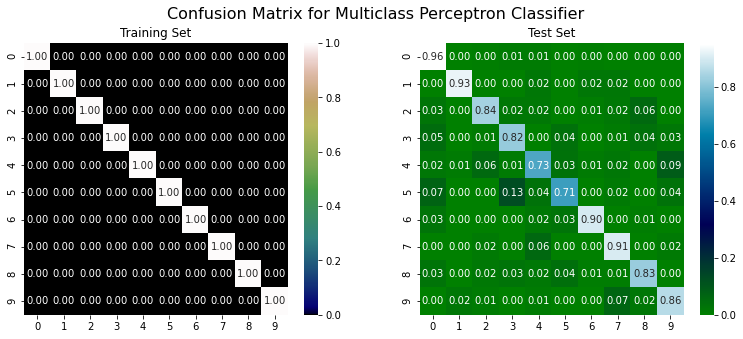

The Single-Layer Perceptron converges after 315 iterations.


In [25]:
# visualize confusion matrix
CM_viz(CM_ppt, ['gist_earth','ocean'], "Multiclass Perceptron Classifier", 'ppt')
print("The Single-Layer Perceptron converges after", ppt.num_iter, "iterations.")

## Early Dropping

Explore the timing for early dropping by plotting the F1-scores on the test set against the maximum number of iterations. Because of the randomness in initial weights, take the average score of $20$ replicate runs for each choice to yield a more reliable result. While the scores do not fluctuate outrageously, it slightly goes down on average after $100$ iterations. Indeed, when the optimization is forced to stop after $75$ iterations, the multi-class perceptron classifier performs better than befroe on labeling test images.

Even so, there are still $10\%$ of images of $5$ in the test set being missclassified as $3$. We can conclude that the handwritings of $3$ and $5$ are the most difficult to distinguish among all digits. Other notable missclassifications occur between $2$ and $4$, and $8$ to $5$; neither has been observed with the distance-based classifiers.

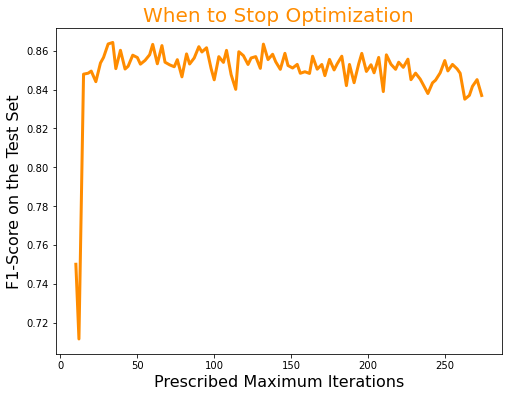

In [83]:
scores = list()
for drop in np.linspace(10, 274, 100):
    earlydrop = CLF_perceptron()
    earlydrop.fit(Train_in, Train_out.loc[:,0], drop=int(drop))
    scores.append(np.mean([f1_score(Test_out.loc[:,0], earlydrop.predict(Test_in), average='macro') for run in range(20)]))

plt.figure(figsize=(8,6))
plt.plot([int(ele) for ele in np.linspace(10,274,100)], scores, color="darkorange", linewidth=3)
plt.xlabel("Prescribed Maximum Iterations", fontsize=16)
plt.ylabel("F1-Score on the Test Set", fontsize=16)
plt.title("When to Stop Optimization", fontsize=20, color='darkorange')
plt.savefig("early_dropping.png")
plt.show()

In [27]:
earlydrop = CLF_perceptron()
earlydrop.fit(Train_in, Train_out.loc[:,0], drop=75)

# classify training images
pred_early_train = earlydrop.predict(Train_in)
CM_early_train = confusion_matrix(Train_out.loc[:,0], pred_early_train, normalize='true')

# classify test images
pred_early_test = earlydrop.predict(Test_in)
CM_early_test = confusion_matrix(Test_out.loc[:,0], pred_early_test, normalize='true')

# save results
CM_earlydrop = {"Train":pd.DataFrame(CM_early_train, index=[d for d in range(1+9)], columns=[d for d in range(1+9)]),
                "Test":pd.DataFrame(CM_early_test, index=[d for d in range(1+9)], columns=[d for d in range(1+9)])}
dump(CM_earlydrop, open("Confusion_Matrix_ppt_earlydrop.p","wb"))

# performance
Performance["Perceptron (max_iter=75)"] = evaluate(Test_out.loc[:,0], pred_early_test)

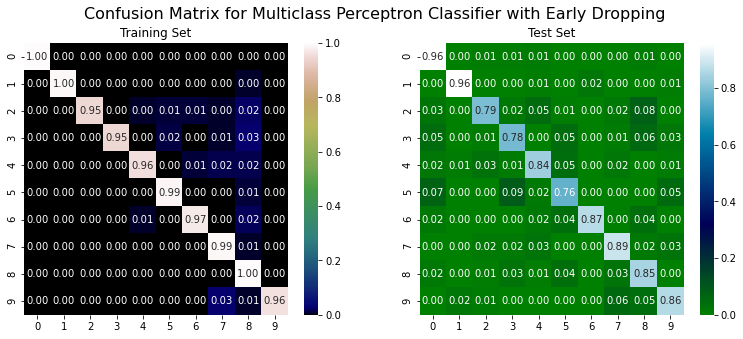

The Single-Layer Perceptron converges after 75 iterations.


In [28]:
# visualize confusion matrix
CM_viz(CM_earlydrop, ['gist_earth','ocean'], "Multiclass Perceptron Classifier with Early Dropping", 'ppt_earlydrop')
print("The Single-Layer Perceptron converges after", earlydrop.num_iter, "iterations.")

# Comparison of Classification Accuracy

Naive distance-based classifier undoubtedly perform the worst. Early dropping did bring up the accuracy of the multi-class perceptron classifier, but not suffice to surpass that of the K-nearest-neighbor classifier with $K=6$.

In [29]:
# compare performance on test set
Performance = pd.DataFrame(Performance, index=['Macro-Precision','Macro-Recall','Macro-F1'])
Performance

,Naive,KNN (K=6),Perceptron,Perceptron (max_iter=75)
Macro-Precision,0.788655,0.910870,0.850116,0.858396
Macro-Recall,0.794906,0.887930,0.848297,0.856052
Macro-F1,0.789013,0.895971,0.848451,0.856028


In [84]:
Performance.to_latex(float_format="%.4f")

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &  Naive &  KNN (K=6) &  Perceptron &  Perceptron (max\\_iter=75) \\\\\n\\midrule\nMacro-Precision & 0.7887 &     0.9109 &      0.8501 &                    0.8584 \\\\\nMacro-Recall    & 0.7949 &     0.8879 &      0.8483 &                    0.8561 \\\\\nMacro-F1        & 0.7890 &     0.8960 &      0.8485 &                    0.8560 \\\\\n\\bottomrule\n\\end{tabular}\n'

# XOR

During each iteration, the forward pass updates the hidden layer and the output layer, and the backward pass updates weights by the chain rule of derivatives and layer values.

$$
\begin{aligned}
&\mathrm{h}(t) = \frac{1}{1+\exp(-t)}
&\mathrm{h}'(t) = h(t) \cdot (1-h(t))
\end{aligned}
$$

$$
\begin{bmatrix}
1 & x_1 & x_2 \\
\end{bmatrix}
\Rightarrow
\begin{bmatrix}
1 & x_1 & x_2 \\
\end{bmatrix}
\cdot
\begin{bmatrix}
\alpha_{0,1} & \alpha_{0,2} \\
\alpha_{1,1} & \alpha_{1,2} \\
\alpha_{2,1} & \alpha_{2,2} \\
\end{bmatrix}
= 
\begin{bmatrix}
z_1 & z_2 \\
\end{bmatrix}
\Rightarrow
\begin{bmatrix}
1 & \mathrm{h}(z_1) & \mathrm{h}(z_2) \\
\end{bmatrix}
\cdot
\begin{bmatrix}
\beta_0 \\ \beta_1 \\ \beta_2 \\
\end{bmatrix}
= y
\Rightarrow
\mathrm{h}(y)
$$

For convenience of computation, weights are organized as a $3$-by-$3$ matrix.

In [62]:
class XOR_net:    
    X = np.array([[0,0],[1,0],[0,1],[1,1]])  # constant attributes
    target = np.array([0,1,1,0])
    Weights = np.zeros([3,3])  # attributes to update
    hidden = np.zeros([3,2])
    output = np.zeros_like(self.target)
    num_iter = 0
    MSE = 0
    num_miss = 4
    
    def initialize(self,W):
        self.Weights = W
        
    def forward(self):      # compute layers
        Z = np.dot(np.hstack((np.ones([4,1]), self.X)), self.Weights[:,:2])
        self.hidden = 1 / (1 + np.exp(-Z))
        Y = np.dot(np.hstack((np.ones([4,1]), self.hidden)), self.Weights[:,-1])
        self.output = 1 / (1 + np.exp(-Y))
        self.MSE = np.sqrt(np.mean((self.target - self.output)**2))
        self.num_miss = 4 - sum((self.output>0.5) == self.target)
        
    def backward(self, eta):   # update weights
        grd = np.zeros_like(self.Weights)
        u = 2 * (self.output - self.target) * (1 - self.output) * self.output
        grd[:,2] = np.array([np.sum(u), np.sum(u * self.hidden[:,0]), np.sum(u * self.hidden[:,1])])
        v1 = u * self.Weights[1,2] * (1 - self.hidden[:,0]) * self.hidden[:,0]
        grd[:,0] = np.array([np.sum(v1), np.sum(v1 * self.X[:,0]), np.sum(v1 * self.X[:,1])])
        v2 = u * self.Weights[2,2] * (1 - self.hidden[:,1]) * self.hidden[:,1]
        grd[:,1] = np.array([np.sum(v2), np.sum(v2 * self.X[:,0]), np.sum(v2 * self.X[:,1])])
        self.Weights = self.Weights - eta*grd
        
    def train(self, eta, drop=50000):
        self.forward()
        while self.num_iter<drop and self.num_miss>0:
            self.backward(eta)
            self.forward()
            self.num_iter += 1
        if not self.num_miss==0:
            print("Arrived maximum number of iterations.")

$\nabla \mathbf{W}$ is a matrix of the same shape as $\mathbf{W}$. The third column of $\nabla \mathbf{W}$ is

$$
\frac{\partial \mathrm{MSE}}{\partial \beta_j} 
= 2 \sum_{i=1}^{i=4}[h(y_i) - T_i] \, \frac{\exp(-y_i)}{(1 + \exp(-y_i))^2} \cdot \frac{\partial y_i}{\partial \beta_j} =
\begin{cases}
2 \sum_{i=1}^{i=4}[h(y_i) - T_i] \, [1-h(y_i)]h(y_i) \cdot 1, \qquad j=0 \\
2 \sum_{i=1}^{i=4}[h(y_i) - T_i] \, [1-h(y_i)]h(y_i) \cdot h(z_{i,1}), \quad j=1 \\
2 \sum_{i=1}^{i=4}[h(y_i) - T_i] \, [1-h(y_i)]h(y_i) \cdot h(z_{i,2}), \quad j=2 \\
\end{cases}
$$

The first column of $\nabla \mathbf{W}$ is

$$
\frac{\partial \mathrm{MSE}}{\partial \alpha_{j,1}} 
= 2 \sum_{i=1}^{i=4}[h(y_i) - T_i] \, \frac{\exp(-y_i)}{(1 + \exp(-y_i))^2} \cdot \beta_1 \frac{\partial h(z_{i,1})}{\partial \alpha_{j,1}} =
\begin{cases}
2 \sum_{i=1}^{i=4}[h(y_i) - T_i] \, [1-h(y_i)]h(y_i) \, [1-h(z_{i,1})]h(z_{i,1})\beta_1 \cdot 1, \qquad j=0 \\
2 \sum_{i=1}^{i=4}[h(y_i) - T_i] \, [1-h(y_i)]h(y_i) \, [1-h(z_{i,1})]h(z_{i,1})\beta_1 \cdot x_{i,1}, \quad j=1 \\
2 \sum_{i=1}^{i=4}[h(y_i) - T_i] \, [1-h(y_i)]h(y_i) \, [1-h(z_{i,1})]h(z_{i,1})\beta_1 \cdot x_{i,2}, \quad j=2 \\
\end{cases}
$$

The second column of $\nabla \mathbf{W}$ is

$$
\frac{\partial \mathrm{MSE}}{\partial \alpha_{j,2}} 
= 2 \sum_{i=1}^{i=4}[h(y_i) - T_i] \, \frac{\exp(-y_i)}{(1 + \exp(-y_i))^2} \cdot \beta_2 \frac{\partial h(z_{i,2})}{\partial \alpha_{j,2}} =
\begin{cases}
2 \sum_{i=1}^{i=4}[h(y_i) - T_i] \, [1-h(y_i)]h(y_i) \, [1-h(z_{i,2})]h(z_{i,2})\beta_2 \cdot 1, \qquad j=0 \\
2 \sum_{i=1}^{i=4}[h(y_i) - T_i] \, [1-h(y_i)]h(y_i) \, [1-h(z_{i,2})]h(z_{i,2})\beta_2 \cdot x_{i,1}, \quad j=1 \\
2 \sum_{i=1}^{i=4}[h(y_i) - T_i] \, [1-h(y_i)]h(y_i) \, [1-h(z_{i,2})]h(z_{i,2})\beta_2 \cdot x_{i,2}, \quad j=2 \\
\end{cases}
$$

where $(T_1, T_2, T_3, T_4) = (0,1,1,0)$ is the ground truth.

## Gaussian Initialization

Initialize every weight by $\mathrm{N}(0,1)$ and for each of the six choices of learning rate, run the training process $5$ times to examine the randomness.

In [71]:
random.seed(3)
Gaussian = dict()
for lr in [0.01, 0.05, 0.1, 0.3, 0.5, 1]:
    lst = list()
    for run in range(5):
        NET = XOR_net()
        NET.initialize(np.random.normal(0,1,size=(3,3)))
        NET.train(eta=lr)
        lst.append(NET.num_iter)
    Gaussian[lr] = lst
Gaussian = pd.DataFrame(Gaussian, index=["run = "+str(1+run) for run in range(5)])
Gaussian.columns = [r"$\eta$ = "+str(lr) for lr in [0.01, 0.05, 0.1, 0.3, 0.5, 1]]
Gaussian

Arrived maximum number of iterations.
Arrived maximum number of iterations.
Arrived maximum number of iterations.
Arrived maximum number of iterations.


,$\eta$ = 0.01,$\eta$ = 0.05,$\eta$ = 0.1,$\eta$ = 0.3,$\eta$ = 0.5,$\eta$ = 1
run = 1,50000,2144,1563,178,15409,270
run = 2,24526,1671,983,499,459,355
run = 3,15576,10976,50000,196,2729,314
run = 4,12657,8285,747,391,470,190
run = 5,50000,4237,738,50000,2197,151


In [72]:
Gaussian.to_latex()

'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &  \\$\\textbackslash eta\\$ = 0.01 &  \\$\\textbackslash eta\\$ = 0.05 &  \\$\\textbackslash eta\\$ = 0.1 &  \\$\\textbackslash eta\\$ = 0.3 &  \\$\\textbackslash eta\\$ = 0.5 &  \\$\\textbackslash eta\\$ = 1 \\\\\n\\midrule\nrun = 1 &          50000 &           2144 &          1563 &           178 &         15409 &         270 \\\\\nrun = 2 &          24526 &           1671 &           983 &           499 &           459 &         355 \\\\\nrun = 3 &          15576 &          10976 &         50000 &           196 &          2729 &         314 \\\\\nrun = 4 &          12657 &           8285 &           747 &           391 &           470 &         190 \\\\\nrun = 5 &          50000 &           4237 &           738 &         50000 &          2197 &         151 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Uniform Initialization

Initialize every weight by $\mathbf{U}(0,1)$ and replicate the previous experiment.

In [69]:
random.seed(11)
Uniform = dict()
for lr in [0.01, 0.05, 0.1, 0.3, 0.5, 1]:
    lst = list()
    for run in range(5):
        NET = XOR_net()
        NET.initialize(np.random.uniform(0,1,size=(3,3)))
        NET.train(eta=lr)
        lst.append(NET.num_iter)
    Uniform[lr] = lst
Uniform = pd.DataFrame(Uniform, index=["run = "+str(1+run) for run in range(5)])
Uniform.columns = [r"$\eta$ = "+str(lr) for lr in [0.01, 0.05, 0.1, 0.3, 0.5, 1]]
Uniform

Arrived maximum number of iterations.
Arrived maximum number of iterations.
Arrived maximum number of iterations.
Arrived maximum number of iterations.
Arrived maximum number of iterations.


,$\eta$ = 0.01,$\eta$ = 0.05,$\eta$ = 0.1,$\eta$ = 0.3,$\eta$ = 0.5,$\eta$ = 1
run = 1,18556,4399,1857,588,50000,253
run = 2,50000,3822,2045,834,435,50000
run = 3,22876,5386,2811,1053,1126,192
run = 4,25321,3408,2652,722,50000,290
run = 5,19691,7786,1872,756,598,50000


In [70]:
Uniform.to_latex()

'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &  \\$\\textbackslash eta\\$ = 0.01 &  \\$\\textbackslash eta\\$ = 0.05 &  \\$\\textbackslash eta\\$ = 0.1 &  \\$\\textbackslash eta\\$ = 0.3 &  \\$\\textbackslash eta\\$ = 0.5 &  \\$\\textbackslash eta\\$ = 1 \\\\\n\\midrule\nrun = 1 &          18556 &           4399 &          1857 &           588 &         50000 &         253 \\\\\nrun = 2 &          50000 &           3822 &          2045 &           834 &           435 &       50000 \\\\\nrun = 3 &          22876 &           5386 &          2811 &          1053 &          1126 &         192 \\\\\nrun = 4 &          25321 &           3408 &          2652 &           722 &         50000 &         290 \\\\\nrun = 5 &          19691 &           7786 &          1872 &           756 &           598 &       50000 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Lazy Approach

Randomly generate weights and execute a forward pass, computing outputs without optimizing weights by backward pass, until we incidentally hit every target. It seems impossible to succeed with $\mathrm{U}(0,1)$ initialization, probably because it does not allow negative weights. And with $\mathrm{N}(0,1)$ and $\mathrm{U}(-1,1)$, on average, such attempts drastically outnumber the iterations required for the backpropagation algorithm to find the proper weights.

In [81]:
Lazy = dict()
drop = 10**6

# Gaussian initialization
lst = list()
for run in range(5):
    NET = XOR_net()
    NET.initialize(np.random.normal(0,1,size=(3,3)))
    NET.forward()
    count = 1
    while NET.num_miss>0 and count<drop:
        NET.initialize(np.random.normal(0,1,size=(3,3)))
        NET.forward()
        count += 1
    lst.append(count)
Lazy["N(0,1)"] = lst


# Uniform initialization
lst = list()
for run in range(5):
    NET = XOR_net()
    NET.initialize(np.random.uniform(0,1,size=(3,3)))
    NET.forward()
    count = 1
    while NET.num_miss>0 and count<drop:
        NET.initialize(np.random.uniform(0,1,size=(3,3)))
        NET.forward()
        count += 1
    lst.append(count)
Lazy["U(0,1)"] = lst

lst = list()
for run in range(5):
    NET = XOR_net()
    NET.initialize(np.random.uniform(-1,1,size=(3,3)))
    NET.forward()
    count = 1
    while NET.num_miss>0 and count<drop:
        NET.initialize(np.random.uniform(-1,1,size=(3,3)))
        NET.forward()
        count += 1
    lst.append(count)
Lazy["U(-1,1)"] = lst

Lazy = pd.DataFrame(Lazy, index=['run = '+str(run+1) for run in range(5)])
Lazy

,"N(0,1)","U(0,1)","U(-1,1)"
run = 1,34425,1000000,1000000
run = 2,226879,1000000,935122
run = 3,155039,1000000,950946
run = 4,195405,1000000,98243
run = 5,67691,1000000,1000000


In [82]:
Lazy.to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  N(0,1) &   U(0,1) &  U(-1,1) \\\\\n\\midrule\nrun = 1 &   34425 &  1000000 &  1000000 \\\\\nrun = 2 &  226879 &  1000000 &   935122 \\\\\nrun = 3 &  155039 &  1000000 &   950946 \\\\\nrun = 4 &  195405 &  1000000 &    98243 \\\\\nrun = 5 &   67691 &  1000000 &  1000000 \\\\\n\\bottomrule\n\\end{tabular}\n'